# Investigación empírica de las dinámicas de la volatilidad de criptomonedas a través de los modelos GARCH 

## 1. Extracción de datos financieros

In [23]:
import yfinance as yf
import pandas as pd
import numpy as np
import pmdarima as pm
import statsmodels.api as sm
import statsmodels.tsa.api as tsa
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf
from scipy import stats
import statsmodels.graphics.tsaplots as sgt 
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline
import seaborn as sns
sns.set_style("dark")
import yfinance as yf

import warnings
warnings.filterwarnings("ignore")

In [24]:
def get_log_returns(ticker):
    """ Generamos la serie temporal de retornos logarítmicos
    Args:
        ticker (str): símbolo del activo en el que calcular la serie
    Returns:
        Series
    """
    adj_close = yf.download(ticker, start = '2016-01-01', end = '2022-06-05')['Adj Close']
    log_returns = 100 * np.log(1 + adj_close.pct_change()).dropna()
    log_returns = log_returns.to_frame()
    return log_returns

btc = get_log_returns('BTC-USD')
tether = get_log_returns('USDT-USD')
sp500 = get_log_returns('^GSPC')

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [25]:
btc = btc.rename(columns = {'Adj Close':'log_returns'})
btc

,log_returns
Date,
2016-01-01,0.871095
2016-01-02,-0.206512
2016-01-03,-0.793798
2016-01-04,0.713712
2016-01-05,-0.261490
...,...
2022-05-31,0.207561
2022-06-01,-6.474693
2022-06-02,2.218263


In [26]:
tether = tether.rename(columns = {'Adj Close':'log_returns'}) 
tether

,log_returns
Date,
2017-11-10,-0.215468
2017-11-11,0.295781
2017-11-12,0.344302
2017-11-13,-0.308639
2017-11-14,-0.249974
...,...
2022-05-31,0.001199
2022-06-01,-0.012806
2022-06-02,0.005702


In [27]:
sp500 = sp500.rename(columns = {'Adj Close':'log_returns'})
sp500

,log_returns
Date,
2016-01-04,-1.542204
2016-01-05,0.201020
2016-01-06,-1.320216
2016-01-07,-2.398582
2016-01-08,-1.089754
...,...
2022-05-27,2.444113
2022-05-31,-0.629414
2022-06-01,-0.751091


In [28]:
def tabla_estadística(series):
    """ Genera tabla estadística descriptiva
    Args:
        series(series) = serie en la que realizamos la tabla
    Returns:
        Dataframe
    """
    describe = pd.DataFrame(series.describe())
    # Skewness
    describe.loc[8] = series.skew()
    # Kurtosis
    describe.loc[9] = series.kurt()
    # Range
    describe.loc[10] = series.max() - series.min()
    # IQR
    describe.loc[11] = series.quantile(.75) - series.quantile(.25)
    # CV 
    describe.loc[12] = series.std()/series.mean()
    describe.rename(index = {8:'Skewness',9:'Kurtosis',10:'Range',11:'IQR',12:'CV'}, inplace = True)
    print(describe)

In [29]:
tabla_estadística(btc)

          log_returns
count     2347.000000
mean         0.180582
std          3.963548
min        -46.473018
25%         -1.381118
50%          0.209642
75%          1.828448
max         22.511895
Skewness    -0.726181
Kurtosis    11.260086
Range       68.984913
IQR          3.209566
CV          21.948720


In [30]:
tabla_estadística(tether)

          log_returns
count     1668.000000
mean        -0.000530
std          0.475292
min         -5.256973
25%         -0.103055
50%         -0.001644
75%          0.099463
max          5.660626
Skewness     0.673250
Kurtosis    40.455851
Range       10.917599
IQR          0.202519
CV        -897.428069


In [31]:
tabla_estadística(sp500)

          log_returns
count     1617.000000
mean         0.043178
std          1.189648
min        -12.765220
25%         -0.323550
50%          0.074553
75%          0.558473
max          8.968323
Skewness    -1.028094
Kurtosis    19.036686
Range       21.733543
IQR          0.882023
CV          27.552165


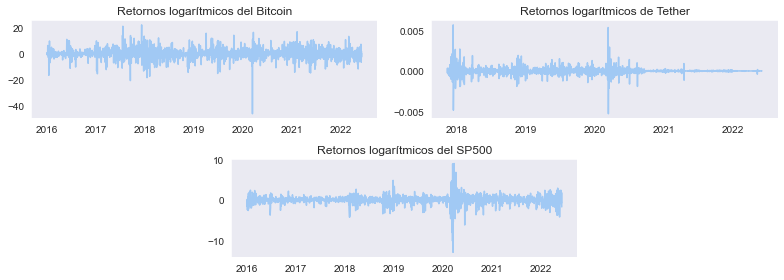

In [32]:
## Graficación de los retornos logarítmicos de los activosb
plt.figure(figsize = (11,4))
sns.set_palette(sns.color_palette("pastel"))
gs = gridspec.GridSpec(4, 4)
ax1 = plt.subplot(gs[:2, :2])
plt.title('Retornos logarítmicos del Bitcoin')
plt.plot(btc)
ax2 = plt.subplot(gs[:2, 2:])
plt.title('Retornos logarítmicos de Tether')
plt.plot(tether/1000)
ax3 = plt.subplot(gs[2:4, 1:3])
plt.title('Retornos logarítmicos del SP500')
plt.plot(sp500)
plt.tight_layout()
plt.show()

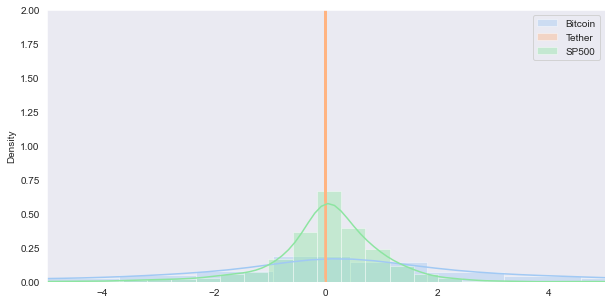

In [33]:
plt.figure(figsize = (10,5))
plt.xlim(-5,5)
plt.ylim(0,2)
sns.set_palette(sns.color_palette("pastel"))
sns.distplot(btc, label = 'Bitcoin')
sns.distplot(tether/1000, label = 'Tether')
sns.distplot(sp500, label = 'SP500')
plt.legend()
plt.show()


## 2. Estimación del ARIMA-GARCH

En este segundo apartado, se realizará todo el procedimiento hasta la validación de los modelos ARIMA-GARCH seleccionados para posteriormente realizar una predicción de la volatilidad de los tres intrumentos de inversión. 

Los pasos que se realizarán en esta sección serán:
    
- **2.1. Modelización ARIMA y tratamiento de los atípicos**: Estimación de un modelo ARIMA para cada serie de retornos logarítmicos, con el fin de incorporar en el modelo componentes de medias móviles, autorregresivos y valores atípicos.
- **2.2. Estudio de los residuos normales y al cuadrado del modelo ARIMA estimado**: Se comprobarán hipótesis de incorrelación de errores y normalidad en los residuos normales y la existencia de correlación entre los errores al cuadrado.
- **2.3. Modelización GARCH**: Estimación de un modelo GARCH básico de orden (1,1). 
    - **2.3.1. Amplicaciones de modelos GARCH**: Estimaciones de modelos GARCH ampliados que permitan mejorar nuestra capacidad explicativa
- **2.4. Estudio de los residuos GARCH estimados**: Demostración de la no existencia de heterocedasticidad y autocorrelación entre los errores al cuadrado como validación del modelo GARCH escogido.

### 2.1. Modelización ARIMA y tratamiento de los datos atípicos (1/4)

Una vez obtenidos las rentabilidades logarítmicas de los tres instrumentos financieros, procedemos al tratamiento de los datos atípicos.

La primera función prepara el DataFrame sobre el que posteriormente se modelizará un ARIMAX (0,0,0). Acepta una serie, el nombre de la serie y el número de desviaciones típicas que queramos usar como criterio para definir los valores atípicos. Por cada valor atípico encontrado, la función creará una columna en el DataFrame con nombre de ese outlier que tomará valor 1 si la observación tiene ese valor y 0 si no lo hace, creando por lo tanto una variable dummy por cada outlier encontrado. La función devolverá el DataFrame final.

La segunda función acepta el DataFrame generado por la anterior función y estima sobre ella un modelo ARIMAX (0,0,0), que permitirá que los outliers sean explicados con un nivel de significancia mayor del 99%. Además de devolver los residuos del modelo, mostrará los resultados de la estimación del modelo, demostrando la significancia de todos los parámetros a más del 99%. 


In [34]:
def showing_outliers(serie, std_criteria):
    """ Presenta los valores atípicos de una serie dada según un criterio de desviación típica
    Args:
        serie (series): serie temporal en la que nos basamos para detectar los outliers
        std_criteria (int): número de veces en la que se debe de salir de las desviación típico un valor
        para ser considerado un valor atípico      
    """
    series = serie.copy()
    desviation = float(series.std()*std_criteria)
    outliers = []
    for index, row in series.iterrows():
        if (float(row) > desviation) or (float(row) < -desviation):
            outliers.append(float(row))
    print('Valores atípicos: ',outliers)
    print('Número de valores atípicos: ', len(outliers))
    
def preparing_temporal_series(serie, std_criteria):
    """Crea una dataframe con columnas binarias de los valores atípicos
    Args:
        serie (series): serie temporal en la que nos basamos para detectar los outliers
        std_criteria (int): número de veces en la que se debe de salir de las desviación típico un valor
        para ser considerado un valor atípico
    
    Returns:
        Dataframe
    """
    series = serie.copy()    
    desviation = float(series.std()*std_criteria)
    # obteniendo lista de outliers
    outliers = []
    for index, row in series.iterrows():
        if (float(row) > desviation) or (float(row) < -desviation):
            outliers.append(float(row))
    # creamos una variable dummy por cada valor atípico
    for outlier in outliers:
        series[str(outlier)] = series['log_returns'].apply(lambda x: 1 if x == outlier else 0)
    return series

def adjusted_model(df, freq = 'D'):
    """ Presenta una estimación SARIMAX tomando los valores atípicos como variables exógenos al modelo
    Args:
        df(Dataframe): serie temporal en la que modelizamos el ARIMAX
        freq (str) : frecuencia temporal de la estimación (opciones: 'd','b','w','m','y')
    
    Returns:
        Residuos del modelo
    """
    _arma_model = pm.auto_arima(y = df['log_returns'], exogenous = df.iloc[:,1:],
                     d = 0,
                     seasonal = False,
                     information_criterion = 'bic',
                     trace = True,
                     stepwise = True)
    print(_arma_model.summary())
    return _arma_model.resid()

In [35]:
for std_candidate in [3,5,7]:
    print('Valores atípicos de {} con {} desviaciones típicas'.center(123, '-').format('bitcoin', std_candidate))
    showing_outliers(btc, std_candidate)

-------------------------------------Valores atípicos de bitcoin con 3 desviaciones típicas------------------------------------
Valores atípicos:  [-16.64338052665779, -13.05752503587256, -15.4476649076822, -12.205008924073008, 14.38615807515655, 21.459581921064387, -20.75298468188717, 14.23295036032813, 12.6296016703469, 12.093108463263826, 18.172416088180857, 22.511895434132782, -13.32232172821606, 13.78513383721832, -12.359779448691187, -18.458172530715174, -17.39821153312485, 12.412693581038274, -14.356147255391308, 16.00419797683949, 12.175582015101313, 11.992989942799603, -15.181967393698741, -13.937670558066412, -12.09936495214672, 14.476109386093217, -46.4730175339773, 16.71043242496126, 11.984140644428901, -14.252813081835994, 17.18205618881233, -14.2967146773037, -14.810707635188663, -11.9521795848678, 13.576425730332167]
Número de valores atípicos:  35
-------------------------------------Valores atípicos de bitcoin con 5 desviaciones típicas---------------------------------

In [36]:
for std_candidate in [3,5,7]:
    print('Valores atípicos de {} con {} desviaciones típicas'.center(123, '-').format('tether', std_candidate))
    showing_outliers(tether, std_candidate)

-------------------------------------Valores atípicos de tether con 3 desviaciones típicas------------------------------------
Valores atípicos:  [1.7505795477082406, 2.130791181877143, 5.660625606298034, -4.819841255840815, -1.8641080108855683, 2.647475492845963, -2.149675915702048, 1.5501122709679496, 2.6981604325763797, -1.915444216551417, -1.8317347406879698, 1.7334463093974892, -1.6625696420604554, 1.8871824697148807, -1.8931134958676081, 1.5783431105178645, -1.427722905445387, 1.9123398009735944, -1.577007372245821, 1.4486216089913446, 1.83480997823081, 1.502744811250073, 5.3393397894479016, -5.256973240306426, -2.114358370727026, 2.9277329753384524, 1.4748188050432245, 1.6916444927254644, -1.4881305479267513, -1.6074832754024264, -1.8985031745432983]
Número de valores atípicos:  31
-------------------------------------Valores atípicos de tether con 5 desviaciones típicas------------------------------------
Valores atípicos:  [5.660625606298034, -4.819841255840815, 2.647475492845

In [37]:
for std_candidate in [3,5,7]:
    print('Valores atípicos de {} con {} desviaciones típicas'.center(123, '-').format('sp500', std_candidate))
    showing_outliers(sp500, std_candidate)

-------------------------------------Valores atípicos de sp500 con 3 desviaciones típicas------------------------------------
Valores atípicos:  [-3.6580792805582627, -4.184254093838143, -3.82590522458017, 4.840317767080503, -4.516813635226115, 4.50108687694132, 4.133634936063314, -7.901041294037148, 4.821505242585911, -5.01028928086054, -9.994485240247352, 8.880840694923595, -12.765219747281742, 5.822631263569171, -5.322227233208024, -4.432762405336681, 8.968323251796326, 6.054383107424656, -4.514636273278691, 6.796824414483035, -6.075269299628893, -3.5757594142185303, -3.592554210857772, -3.6959159784694147, -3.630067756409906, -4.123380929124887]
Número de valores atípicos:  26
-------------------------------------Valores atípicos de sp500 con 5 desviaciones típicas------------------------------------
Valores atípicos:  [-7.901041294037148, -9.994485240247352, 8.880840694923595, -12.765219747281742, 8.968323251796326, 6.054383107424656, 6.796824414483035, -6.075269299628893]
Número 

In [38]:
btc_df = preparing_temporal_series(btc, 5)
btc_resid = adjusted_model(btc_df)

Performing stepwise search to minimize bic
 ARIMA(2,0,2)(0,0,0)[0]             : BIC=13157.451, Time=0.61 sec
 ARIMA(0,0,0)(0,0,0)[0]             : BIC=13136.421, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : BIC=13142.194, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0]             : BIC=13142.305, Time=0.06 sec
 ARIMA(1,0,1)(0,0,0)[0]             : BIC=13147.698, Time=0.17 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : BIC=13139.313, Time=0.04 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0]          
Total fit time: 0.946 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2347
Model:                        SARIMAX   Log Likelihood               -6564.330
Date:                Tue, 30 Aug 2022   AIC                          13130.660
Time:                        17:46:23   BIC                          13136.421
Sample:                    01-01-2016   HQIC                         13132.758
    

In [39]:
tether_df = preparing_temporal_series(tether, 5)
tether_resid = adjusted_model(tether_df)

Performing stepwise search to minimize bic
 ARIMA(2,0,2)(0,0,0)[0]             : BIC=1807.746, Time=0.44 sec
 ARIMA(0,0,0)(0,0,0)[0]             : BIC=2258.595, Time=0.06 sec
 ARIMA(1,0,0)(0,0,0)[0]             : BIC=2009.587, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0]             : BIC=1825.247, Time=0.07 sec
 ARIMA(1,0,2)(0,0,0)[0]             : BIC=1800.114, Time=0.25 sec
 ARIMA(0,0,2)(0,0,0)[0]             : BIC=1800.881, Time=0.12 sec
 ARIMA(1,0,1)(0,0,0)[0]             : BIC=1795.220, Time=0.13 sec
 ARIMA(2,0,1)(0,0,0)[0]             : BIC=1800.364, Time=0.19 sec
 ARIMA(2,0,0)(0,0,0)[0]             : BIC=1928.464, Time=0.08 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : BIC=1802.610, Time=0.40 sec

Best model:  ARIMA(1,0,1)(0,0,0)[0]          
Total fit time: 1.780 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1668
Model:               SARIMAX(1, 0, 1)   Log Likelihood        

In [40]:
sp500_df = preparing_temporal_series(sp500, 5)
sp500_resid = adjusted_model(sp500_df)

Performing stepwise search to minimize bic
 ARIMA(2,0,2)(0,0,0)[0]             : BIC=4999.697, Time=0.55 sec
 ARIMA(0,0,0)(0,0,0)[0]             : BIC=5158.973, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : BIC=5096.976, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : BIC=5110.179, Time=0.05 sec
 ARIMA(1,0,2)(0,0,0)[0]             : BIC=5093.100, Time=0.15 sec
 ARIMA(2,0,1)(0,0,0)[0]             : BIC=5095.469, Time=0.13 sec
 ARIMA(3,0,2)(0,0,0)[0]             : BIC=5104.375, Time=0.60 sec
 ARIMA(2,0,3)(0,0,0)[0]             : BIC=5106.066, Time=0.52 sec
 ARIMA(1,0,1)(0,0,0)[0]             : BIC=5094.833, Time=0.08 sec
 ARIMA(1,0,3)(0,0,0)[0]             : BIC=5099.132, Time=0.48 sec
 ARIMA(3,0,1)(0,0,0)[0]             : BIC=5035.384, Time=0.35 sec
 ARIMA(3,0,3)(0,0,0)[0]             : BIC=5014.322, Time=1.20 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : BIC=5004.164, Time=1.04 sec

Best model:  ARIMA(2,0,2)(0,0,0)[0]          
Total fit time: 5.204 seconds
                      

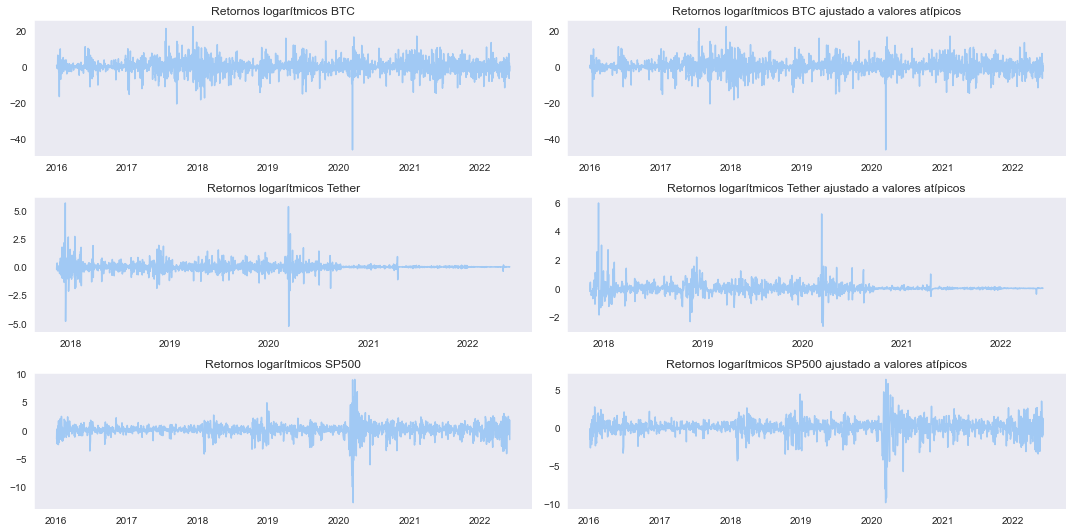

In [41]:
plt.figure(figsize = (15,7.5))
plt.subplot(321)
plt.title('Retornos logarítmicos BTC')
plt.plot(btc)
plt.subplot(322)
plt.title('Retornos logarítmicos BTC ajustado a valores atípicos')
plt.plot(btc_resid)
plt.subplot(323)
plt.title('Retornos logarítmicos Tether')
plt.plot(tether)
plt.subplot(324)
plt.title('Retornos logarítmicos Tether ajustado a valores atípicos')
plt.plot(tether_resid)
plt.subplot(325)
plt.title('Retornos logarítmicos SP500')
plt.plot(sp500)
plt.subplot(326)
plt.title('Retornos logarítmicos SP500 ajustado a valores atípicos')
plt.plot(sp500_resid)
plt.tight_layout()
plt.show()

### 2.2. Estudio de los residuos normales y al cuadrado del modelo ARIMA estimado (2/4)

#### Análisis de los residuos normales del modelo ARIMA

Para la evaluación de los residuos normales del modelo ARIMA pediremos el cumplimiento de tres hipótesis:
- Incorrelación de los errores a través de la función de autocorrelación.
- Incorrelación de los errores a través de la función de autocorrelación parcial.
- Normalidad en los residuos a través del gráfico Q-Q.

In [42]:
def correlograma(series, title = '', lags = 20):
    fig, axs = plt.subplots(2,2, figsize=(10, 6))
    fig.suptitle(title, fontsize=16, x = 0.53)
    axs[0,0].plot(series)
    axs[0,0].set_xticklabels([])
    stats.probplot(series.array, plot=axs[0,1])
    sgt.plot_pacf(series, lags = lags, zero = False, ax = axs[1,0])
    sgt.plot_acf(series, lags = lags, zero = False, ax = axs[1,1])
    plt.tight_layout()
    plt.show()

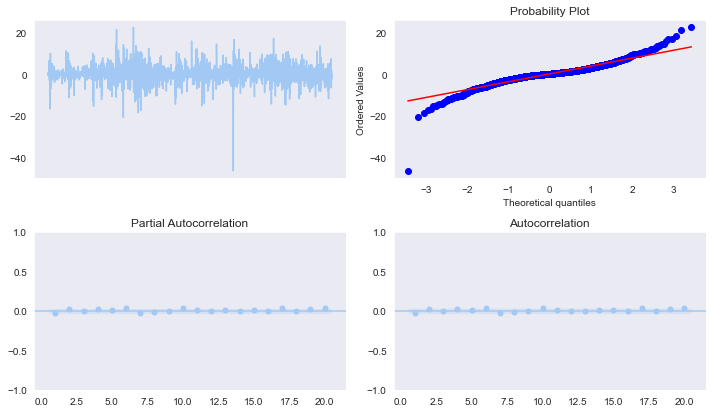

In [43]:
correlograma(btc_resid, lags = 20)

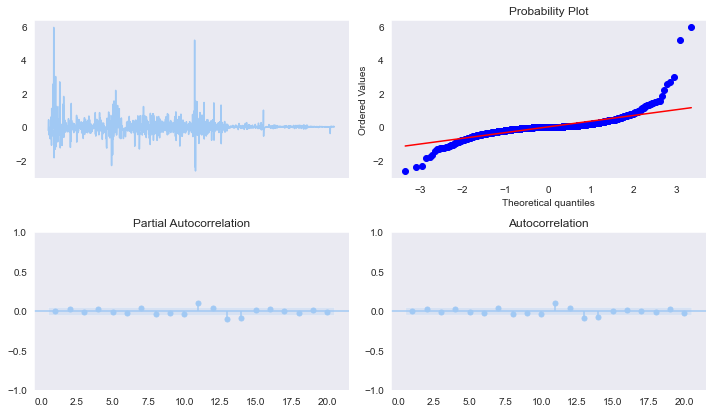

In [44]:
correlograma(tether_resid, lags = 20)

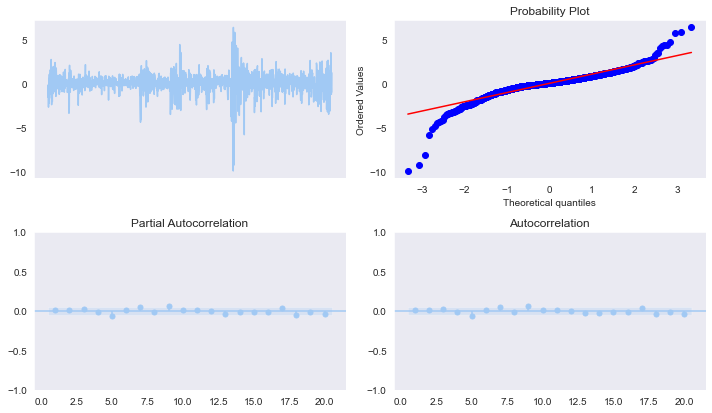

In [45]:
correlograma(sp500_resid, lags = 20)

Según los correlogramas presentados observamos que, de los primeros 40 retrasos de los retornos logarítmicos, la gran mayoría no son significativos tanto en la función de autocorrelación como en la de autocorrelación parcial. Aquellos que lo son pueden ser considerados aleatorios. 

Por el otro lado, en cuanto al QQ plot, podemos ver que los valores se aproximan a la normalidad aunque en las colas se distancien de la línea de referencia, lo que nos da indicios de existencia de heterocedasticidad condicionada.

En conclusión, podemos considerar que los residuos del modelo ARIMA no tienen ningún problema que nos obligue a tener que buscar otro modelo.

#### Análisis de los residuos al cuadrado del modelo ARIMA

Para la evaluación de los residuos al cuadrado del modelo ARIMA haremos lo siguiente:
- Buscaremos la autocorrelación de los errores a través de la función de autocorrelación y de autocorrelación parcial. Al contrario que con los residuos normales, los errores esta vez deben ser en su mayoría significativos.
- Aplicaremos el test Box-Jenkins, que nos informará de la existencia de efecto ARCH en los residuos.

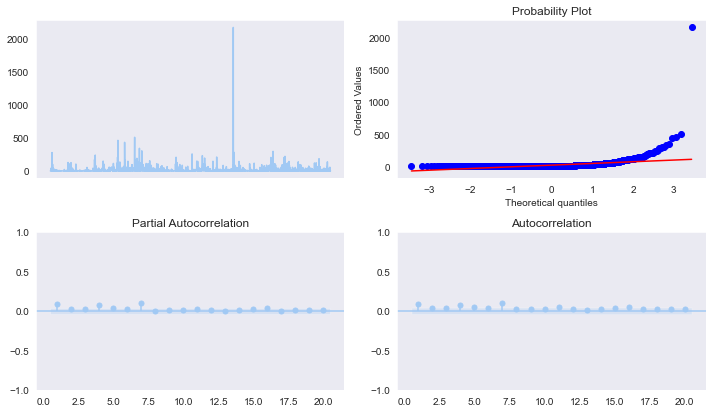

In [46]:
correlograma(btc_resid**2, lags = 20)

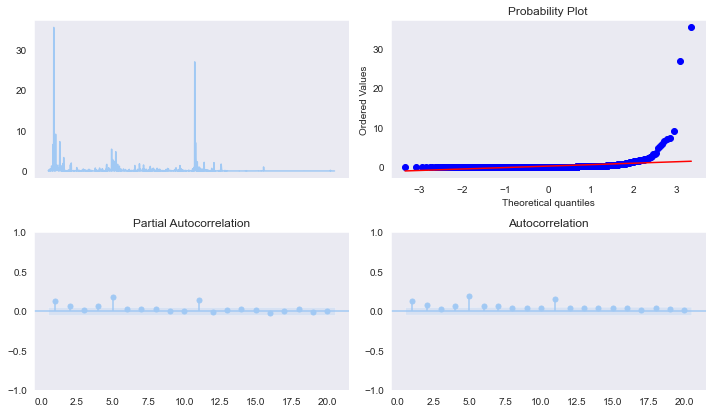

In [47]:
correlograma(tether_resid**2, lags = 20)

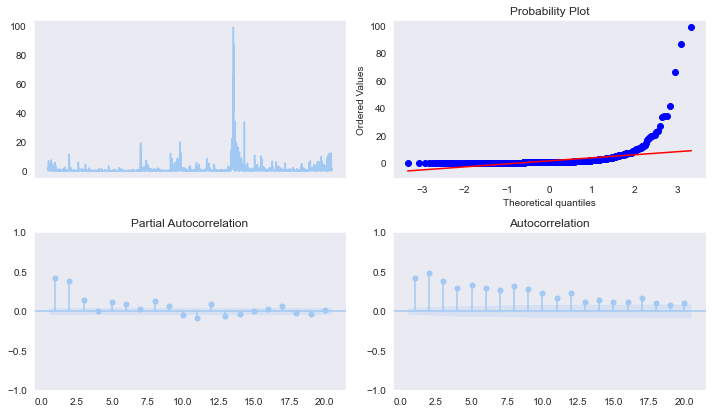

In [48]:
correlograma(sp500_resid**2, lags = 20)

In [49]:
for asset, name in zip([btc_resid**2, tether_resid**2, sp500_resid**2], ['bitcoin','tether','SP500']):
    print('Test de Box-Ljung para {}'.center(125, '-').format(str(name)))
    print(sm.stats.acorr_ljungbox(asset, lags=[40], return_df=True))

--------------------------------------------------Test de Box-Ljung para bitcoin--------------------------------------------------
       lb_stat     lb_pvalue
40  111.617516  1.096354e-08
--------------------------------------------------Test de Box-Ljung para tether--------------------------------------------------
       lb_stat     lb_pvalue
40  220.383243  8.736605e-27
--------------------------------------------------Test de Box-Ljung para SP500--------------------------------------------------
        lb_stat  lb_pvalue
40  2205.247953        0.0


La función de autocorrelación y de autocorrelación parcial demuestra una clara significancia de los retrasos de los residuos logarítmicos al cuadrado de los tres instrumentos de inversión. 

Además, se rechaza por tres veces la hipótesis nula del Test de Box-Ljung, verificando la correlación entre sí de los errores al cuadrado.

### 2.3. Modelización GARCH (3/4)

En este apartado se estiman 6 tipos de modelos GARCH: GARCH, FIGARCH, EGARCH, GJR-GARCH y TARCH. A través de una función, se presenta una tabla donde se recogen los valores de los parámetros de cada modelo junto a su significancia en paréntesis junto a los criterios de información AIC, BIC y loglikelihood. 

El criterio de selección del mejor modelo será el que minimice los dos primeros criterios de información mencionados.

In [55]:
!pip install arch

     -------------------------------------- 843.6/843.6 kB 8.9 MB/s eta 0:00:00
  Using cached statsmodels-0.13.2-cp310-cp310-win_amd64.whl (9.1 MB)
  Using cached property_cached-1.6.4-py2.py3-none-any.whl (7.8 kB)
     --------------------------------------- 38.6/38.6 MB 15.9 MB/s eta 0:00:00
  Using cached patsy-0.5.2-py2.py3-none-any.whl (233 kB)
  Using cached packaging-21.3-py3-none-any.whl (40 kB)
  Using cached pyparsing-3.0.9-py3-none-any.whl (98 kB)


In [57]:
from arch import arch_model

ModuleNotFoundError: No module named 'arch'

In [58]:
def garch_table(arima_residuals):
    garch_table = pd.DataFrame()
    for model in ['GARCH', 'FIGARCH', 'EGARCH', 'HARCH', 'GJR-GARCH', 'TARCH']:
        if model in ['GARCH','FIGARCH','EGARCH','HARCH']:
            basic_garch = arch_model(arima_residuals, p = 1, q = 1, mean = 'Zero', vol = model, dist = 't')
        if model == 'GJR-GARCH':
            basic_garch = arch_model(arima_residuals, p = 1, q = 1, o = 1, mean = 'Zero', dist = 't')
        if model == 'TARCH':
            basic_garch = arch_model(arima_residuals, p = 1, q = 1, o = 1, power = 1.0, mean = 'Zero', dist = 't')          
        gm_result = basic_garch.fit(update_freq = 4, disp = 0)
        def p_value_criteria(x):
            if x < 0.001:
                return ' (***)'
            elif x < 0.01:
                return ' (**)'
            elif x < 0.05:
                return ' (*)'
        p_values = gm_result.pvalues.apply(p_value_criteria)
        params_series = round(gm_result.params, 3).astype(str) + p_values
        garch_table[model] = pd.concat([params_series, pd.Series({'AIC': round(gm_result.aic,4)}), pd.Series({'BIC': round(gm_result.bic,4)}),
                                       pd.Series({'loglikelihood': round(gm_result.loglikelihood,4)})])
    garch_table = garch_table.fillna('-')
    return garch_table

In [59]:
garch_table(btc_resid)

NameError: name 'arch_model' is not defined

In [60]:
garch_table(tether_resid)

NameError: name 'arch_model' is not defined

In [ ]:
garch_table(sp500_resid)

Como podemos observar, el mejor modelo estimador tanto de bitcoin como de tether es el modelo E-GARCH. Por otro lado, el modelo TARCH/ZARCH consigue el mejor resultado para el SP500.

### 2.4. Estudio de los residuos GARCH estimados (4/4)

En este apartado, verificaremos si los modelos GARCH escogidos consiguen eliminar la heterocedasticidad del modelo. Lo haremos estudiando la no autocorrelación entre los errores estandarizados al cuadrado de estos con el test de box-ljung para 40 niveles de retardo.

In [ ]:
def ljung_box(garch_result, asset):
    # creando residuos estandarizados
    plt.figure(figsize = (11,4))
    residuals = garch_result.resid
    volatility = garch_result.conditional_volatility
    squared_standardized_residuals = (residuals/volatility)**2
    # test ljung-box
    for i in range(1,40):
        p_value = float(sm.stats.acorr_ljungbox(squared_standardized_residuals, lags=[i], return_df=True)['lb_pvalue'])
        plt.scatter(i, p_value, marker = 'X')
    plt.axhline(0.05)
    plt.axhline(0.1)
    plt.xlabel('Retardos')
    plt.ylabel('P-valor')
    plt.ylim(0,1)
    plt.show()
        

In [ ]:
plt.subplot(311)
btc_garch = arch_model(btc_resid, p = 1, q = 1, mean = 'Zero', vol = 'EGARCH', dist = 't')
btc_garch_result = btc_garch.fit(update_freq = 4, disp = 0)
ljung_box(btc_garch_result, 'bitcoin')
plt.subplot(312)
tether_garch = arch_model(tether_resid, p = 1, q = 1, mean = 'Zero', vol = 'EGARCH', dist = 't')
tether_garch_result = tether_garch.fit(update_freq = 4, disp = 0)
ljung_box(tether_garch_result, 'tether')
plt.subplot(313)
sp500_garch = arch_model(sp500_resid, p = 1, q = 1, o = 1, mean = 'Zero', dist = 't') 
sp500_garch_result = sp500_garch.fit(update_freq = 4, disp = 0)
ljung_box(sp500_garch_result, 'SP500')
plt.show()

In [ ]:
plt.figure(figsize = (16,4))
plt.plot(btc_garch_result.conditional_volatility, label = 'Bitcoin')
plt.plot(tether_garch_result.conditional_volatility, label = 'Tether')
plt.plot(sp500_garch_result.conditional_volatility, label = 'SP500')
plt.legend(loc = 'upper right')
plt.show()


In [ ]:
btc_vol = btc_garch_result.conditional_volatility
tether_vol = tether_garch_result.conditional_volatility
sp500_vol = sp500_garch_result.conditional_volatility

In [ ]:
btc_std_vol = (btc_vol - btc_vol.min())/(btc_vol.max() - btc_vol.min())
tether_std_vol = (tether_vol - tether_vol.min())/(tether_vol.max() - tether_vol.min())
sp500_std_vol = (sp500_vol - sp500_vol.min())/(sp500_vol.max() - sp500_vol.min())

In [ ]:
plt.figure(figsize = (16,4))
plt.plot(btc_std_vol, label = 'Bitcoin')
plt.plot(tether_std_vol, label = 'Tether')
plt.plot(sp500_std_vol, label = 'SP500')
plt.legend()
plt.show()